# tensorflow
## 自定义cost function
## 自定义layer
## 自定义activation function

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [9]:
from sklearn.datasets import fetch_california_housing

# 下载本地文件，修改fetch_california_housing 内部配置
housing = fetch_california_housing()

In [15]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

In [16]:
from sklearn.preprocessing import StandardScaler

# 标准化
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler = scaler.transform(x_test)

In [59]:
# 自定义cost function
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# input_shape hiddenlayer-1th 指定输入shape
model = keras.models.Sequential(
    [keras.layers.Dense(30, activation='relu', input_shape=x_train.shape[1:]), keras.layers.Dense(1), ])
model.summary()  # 相关参数、信息展示
# 优化器adam 自动更新learning rate
model.compile(loss=customized_mse, optimizer="sgd", metrics=["mean_squared_error"])
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4)]

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 30)                270       
                                                                 
 dense_29 (Dense)            (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [60]:
with tf.device('/GPU:0'):
    history = model.fit(x_train_scaler, y_train,
                        validation_data=(x_valid_scaler, y_valid),
                        epochs=100,
                        callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 1.0707 - mean_squared_error: 1.0707 - val_loss: 0.5260 - val_mean_squared_error: 0.5260
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4456 - mean_squared_error: 0.4456 - val_loss: 0.4518 - val_mean_squared_error: 0.4518
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4145 - mean_squared_error: 0.4145 - val_loss: 0.4309 - val_mean_squared_error: 0.4309
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3963 - mean_squared_error: 0.3963 - val_loss: 0.4115 - val_mean_squared_error: 0.4115
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3864 - mean_squared_error: 0.3864 - val_loss: 0.4050 - val_mean_squared_error: 0.4050
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3847 - mean_squared_error: 0.3847 - val_loss: 0.3964 - val_mean_squared_error: 0.3964
Epoch 7/100
363/363 [=

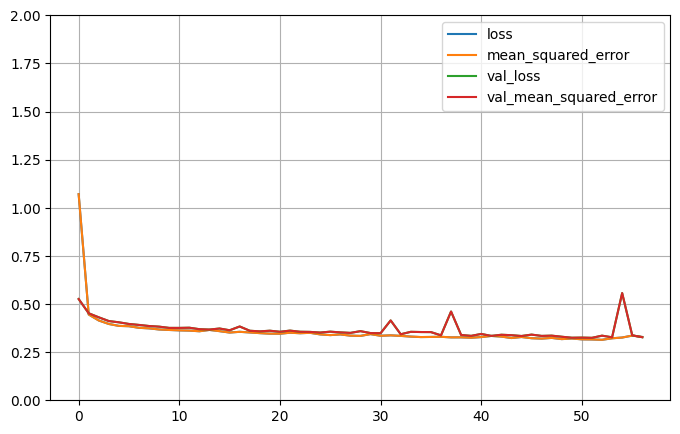

In [61]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
plot_learning_curves(history)

In [62]:
model.evaluate(x_test_scaler,y_test,verbose=0)

[0.3348134756088257, 0.3348134756088257]

In [63]:
# 自定义layers
# tf.nn.softplus : log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda x: tf.math.log(1+tf.math.exp(x)))

# layers
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer,self).__init__(**kwargs)

    def build(self, input_shape):
        # w初始分布
        self.kernel = self.add_weight(name = 'kernel',
                                      shape = (input_shape[1], self.units),
                                      initializer = 'uniform',#使用均匀分布的方法去初始化kernel
                                      trainable = True)
        # b 偏置值
        self.bias = self.add_weight(name = 'bias',
                                    shape = (self.units, ),
                                    initializer = 'zeros',
                                    trainable = True)
        #接着我们要继承父类的build
        super(CustomizedDenseLayer, self).build(input_shape)

    def call(self, x):
        return self.activation(x @ self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu',
                         input_shape=x_train.shape[1:]),  #这里传入的是特征数
    CustomizedDenseLayer(1,activation=customized_softplus),
])
model.summary()
model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-3)]

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 customized_dense_layer (Cus  (None, 30)               270       
 tomizedDenseLayer)                                              
                                                                 
 customized_dense_layer_1 (C  (None, 1)                31        
 ustomizedDenseLayer)                                            
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(x_train_scaler, y_train,
                    validation_data=(x_valid_scaler,y_valid),
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 1.2231 - val_loss: 0.6783
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5937 - val_loss: 0.5867
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5220 - val_loss: 0.5253
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4792 - val_loss: 0.4995
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4616 - val_loss: 0.4885
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4614 - val_loss: 0.4706
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4437 - val_loss: 0.4683
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4363 - val_loss: 0.4819
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4285 - val_loss: 0.4344
Epoch 10/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4272 - val_loss: 0.4506

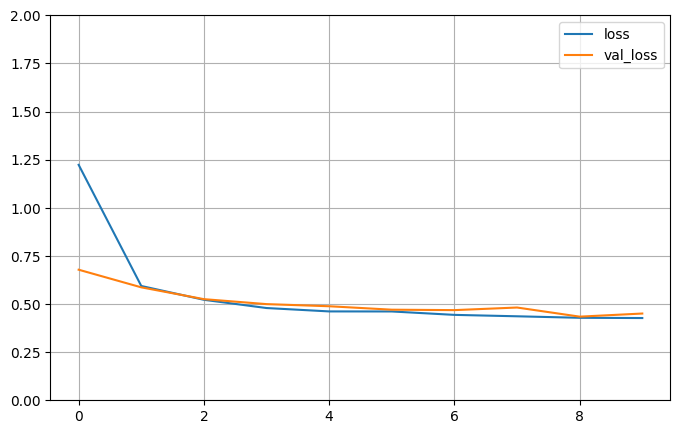

In [65]:
plot_learning_curves(history)

In [67]:
model.evaluate(x_test_scaler,y_test,verbose=0)

0.4461187422275543